In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib
from matplotlib import pyplot,pylab
plt = pyplot
import scipy
import seaborn as sns
sns.set_style('white')
import string
import pandas as pd
import json
import pymongo as pm
from glob import glob
from IPython.display import clear_output
import itertools 
from random import sample
import random
import importlib
from PIL import Image
import re

### set up project paths

In [2]:
## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'../..'))
data_dir = os.path.abspath(os.path.join(curr_dir,'../..','data')) ## use relative paths
stim_dir = os.path.abspath(os.path.join(proj_dir,'stimuli'))
analysis_dir = os.path.abspath(os.path.join(curr_dir,'../..','analysis')) ## use relative paths
plot_dir =  os.path.abspath(os.path.join(curr_dir,'../..','results','plots'))
csv_dir = os.path.join(proj_dir, 'results','csv')
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketch_stim_trials'))
catch_dir = os.path.abspath(os.path.join(proj_dir,'stimuli/classify_iternum2/catch_trial_stimuli'))    # we want to get the stims for the catch trials in our rating task


## add helpers to python path
import sys
if os.path.join(proj_dir, 'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'utils'))
import utils as h    


### inspect stims and get image paths 

In [3]:
## get sketch paths
path_to_sketches = sketch_dir
im_list = h.list_files(sketch_dir)
assert len(im_list)==36*59 # num trials per game * num kosher games

## get catch stim paths
path_to_catches = catch_dir
catch_list = h.list_files(catch_dir)
assert len(catch_list)==11

catch_list

['/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch9.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch8.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch3.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch2.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch1.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch5.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch4.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch6.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch10.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch11.png',
 '/Users/alles/repos/iterated_number/s

In [5]:
## sort stims in place
importlib.reload(h)
h.sort_nicely(im_list)
len(im_list)

2124

/Users/alles/repos/iterated_number/sketch_stim_trials/2555-e7e33493-a4b5-4ff1-8a21-5a9afe2129d1_20deer_trial1.png


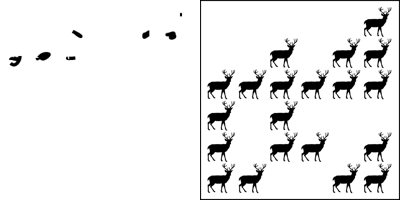

In [6]:
## manually inspect the images
imwidth = 400
imheight = 200
fname = im_list[500]
print(fname)
Image.open(fname).resize((imwidth,imheight))

### upload stims to s3

In [7]:
import boto3
import botocore

In [8]:
bucket_name = 'iternum2-sketch-stims'
full_sketch_paths = h.list_files(path_to_sketches)
h.sort_nicely(full_sketch_paths)

In [17]:
## helper to speed things up by not uploading images if they already exist, can be overriden 
def check_exists(s3, bucket_name, stim_name):
    try:
        s3.Object(bucket_name,stim_name).load()    
        return True
    except botocore.exceptions.ClientError as e:    
        if (e.response['Error']['Code'] == "404"):
            print('The object does not exist.')
            return False
        else:
            print('Something else has gone wrong with {}'.format(stim_name))
            


In [19]:
print(check_exists(boto3.resource('s3'), bucket_name, fname.split('/')[-1]))
print(fname.split('/')[-1])
# print(len(im_list))

# print(full_sketch_paths[5])

The object does not exist.
False
2555-e7e33493-a4b5-4ff1-8a21-5a9afe2129d1_20deer_trial1.png


In [15]:

# access the password and username for s3 from our local directory
access_id = pd.read_csv(os.path.abspath(os.path.join(curr_dir,'../../../../.aws/credentials')), header = None).values[1][0].split('=')[-1]          
access_key = pd.read_csv(os.path.abspath(os.path.join(curr_dir,'../../../../.aws/credentials')), header = None).values[2][0].split('=')[-1]      


In [21]:
reallyRun = 0
if reallyRun: 
    ## tell user some useful information
    print('Path to stimuli is : {}'.format(path_to_sketches))
    print('Uploading to this bucket: {}'.format(bucket_name))

    ## establish connection to s3 
#     s3 = boto3.resource('s3')
    s3 = boto3.resource('s3', 
                  region_name='us-east-1', 
                  aws_access_key_id=access_id, #"STORE THIS LOCALLY! Boto3 should be accessing ~/.aws/credentials but it's not for some reason",     
                  aws_secret_access_key= access_key ) #'THIS TOO!'
    
    ## create a bucket with the appropriate bucket name
    try: 
        b = s3.create_bucket(Bucket=bucket_name) 
        print('Created new bucket.')
    except Exception as e:
        print(e)
        b = s3.Bucket(bucket_name)
        print('Bucket already exists.')

    ## do we want to overwrite files on s3?
    overwrite = False
    
    ## set bucket and objects to public
    b.Acl().put(ACL='public-read') ## sets bucket to public

    ## now let's loop through stim paths and actually upload to s3 (woot!)
    for i,path_to_file in enumerate(full_sketch_paths):
        stim_name = path_to_file.split('/')[-1]
        if ((check_exists(s3, bucket_name, stim_name)==False) | (overwrite==True)):
            print('Now uploading {} | {} of {}'.format(path_to_file.split('/')[-1],(i+1),len(full_sketch_paths)))
            s3.Object(bucket_name,stim_name).put(Body=open(path_to_file,'rb')) ## upload stimuli
            s3.Object(bucket_name,stim_name).Acl().put(ACL='public-read') ## set access controls
        else: 
            print('Skipping {} | {} of {} because it already exists.'.format(path_to_file.split('/')[-1],(i+1),len(full_stim_paths)))
        clear_output(wait=True)

    print('Done uploading images!')

Done uploading images!


In [9]:
# example:
# https://iternum2-sketch-stims.s3.amazonaws.com/0326-4c44297a-fe08-4e67-9575-7bfe54c67f58_15bear_trial12.png

sketches = [i.split('/')[-1] for i in full_sketch_paths if i.split('/')[-1] != '.DS_Store']

to_include = pd.DataFrame(columns = ["URL"])

for i in range(len(sketches)): # for every sketch
    name = sketches[i].split('_') # split up its metadata
    
                                                             #    gameID    cardinality/animal   trial#
    stimurl = "https://iternum2-sketch-stims.s3.amazonaws.com/" + name[0] + '_' + name[1] + '_' + name[2]
    to_include.loc[len(to_include)] = np.array([stimurl])
    
len(to_include)

2124

In [10]:
# now divide this into 36 paradigms
# and upload each paradigm as a big object to the mongo collection
# within each paradigm, have a bunch of trials, each of which is a sketch-stim pair

random_seed = 619

to_include = to_include.sample(frac = 1,random_state=random_seed)  # just totally random sampling

# for p in range(36):
#     stimrow = to_include.sample(n=2,replace=False,random_state=random_seed)
#     to_include = to_include.drop(index = stimrow.index)
#     #print(stimrow)
# print(len(to_include))

to_include

,URL
226,https://iternum2-sketch-stims.s3.amazonaws.com...
1988,https://iternum2-sketch-stims.s3.amazonaws.com...
1763,https://iternum2-sketch-stims.s3.amazonaws.com...
1997,https://iternum2-sketch-stims.s3.amazonaws.com...
783,https://iternum2-sketch-stims.s3.amazonaws.com...
...,...
110,https://iternum2-sketch-stims.s3.amazonaws.com...
231,https://iternum2-sketch-stims.s3.amazonaws.com...
2,https://iternum2-sketch-stims.s3.amazonaws.com...
885,https://iternum2-sketch-stims.s3.amazonaws.com...


In [16]:
catch_urls = ['https://iternum-recog-catches.s3.amazonaws.com/catch1.png',
              'https://iternum-recog-catches.s3.amazonaws.com/catch2.png',
              'https://iternum-recog-catches.s3.amazonaws.com/catch3.png',
              'https://iternum-recog-catches.s3.amazonaws.com/catch4.png',
              'https://iternum-recog-catches.s3.amazonaws.com/catch5.png',
              'https://iternum-recog-catches.s3.amazonaws.com/catch6.png',
              'https://iternum-recog-catches.s3.amazonaws.com/catch7.png',
              'https://iternum-recog-catches.s3.amazonaws.com/catch8.png',
              'https://iternum-recog-catches.s3.amazonaws.com/catch9.png',
              'https://iternum-recog-catches.s3.amazonaws.com/catch10.png',
              'https://iternum-recog-catches.s3.amazonaws.com/catch11.png']
paradigms = []

for p in range(36):
    catches = catch_urls
    meta = []
    thing = to_include[p*59:p*59+59].reset_index().drop('index',axis=1)
    counter = 0
    
    random.seed(p)
#     random.shuffle(catches)
    
    for i,c in enumerate(catches):    # just put all the catches at the beginning, we'll intersperse on index.html
        catch = {'cardinality':None,
                 'animal':None,
                 'origTrialNum':None,
                 'URL':catches[i],
                 'catch':True}
        meta.append(catch)
    
    for row in thing.iterrows():
        counter += 1
        url = row[1][0]
        obj = url.split('_')[-2]
        cardinality,animal = re.split('(\d+)',obj)[1:3]
        origTrial = url.split('_')[-1].split('.')[0]
        origTrialNum = re.split('(\d+)',origTrial)[1]
        
        trial = {'cardinality':cardinality,
                 'animal':animal,
                 'origTrialNum':origTrialNum,
                 'URL':url,
                 'catch':False}
        meta.append(trial)
        
#         if counter % 10 == 0:
            
#             catch = {'cardinality':None,
#                      'animal':None,
#                      'origTrialNum':None,
#                      'URL':catches[int((counter/10) - 1)],
#                      'catch':True}
#             meta.append(catch)
        
    
    paradigm = {'versionID':p,        # which partition is it (set of sketches) ?
                'games':[],
                'all_games':[], # empty list to be filled with classification games as they happen    
                'meta':meta}
    paradigms.append(paradigm)



In [17]:
# for i in paradigms:
#     print(i['versionID'], i['games'],i['meta'][5]['cardinality'],i['meta'][5]['animal'])
paradigms[0]#['meta']

{'versionID': 0,
 'games': [],
 'all_games': [],
 'meta': [{'cardinality': None,
   'animal': None,
   'origTrialNum': None,
   'URL': 'https://iternum-recog-catches.s3.amazonaws.com/catch1.png',
   'catch': True},
  {'cardinality': None,
   'animal': None,
   'origTrialNum': None,
   'URL': 'https://iternum-recog-catches.s3.amazonaws.com/catch2.png',
   'catch': True},
  {'cardinality': None,
   'animal': None,
   'origTrialNum': None,
   'URL': 'https://iternum-recog-catches.s3.amazonaws.com/catch3.png',
   'catch': True},
  {'cardinality': None,
   'animal': None,
   'origTrialNum': None,
   'URL': 'https://iternum-recog-catches.s3.amazonaws.com/catch4.png',
   'catch': True},
  {'cardinality': None,
   'animal': None,
   'origTrialNum': None,
   'URL': 'https://iternum-recog-catches.s3.amazonaws.com/catch5.png',
   'catch': True},
  {'cardinality': None,
   'animal': None,
   'origTrialNum': None,
   'URL': 'https://iternum-recog-catches.s3.amazonaws.com/catch6.png',
   'catch': Tr

In [18]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017') 
db = conn['stimuli']
coll = db['iternum2_recog2']

collist = db.list_collection_names({})

if "iternum2_recog2" in collist:
    print("The collection exists.")
else:
    db.create_collection('iternum2_recog2')

The collection exists.


In [ ]:
## now really insert data
reallyRun = False



## insert the data
if reallyRun:
    for (i,j) in enumerate(paradigms):
        print('%d of %d uploaded ...' % (i+1,len(paradigms)))
        clear_output(wait=True)
        coll.insert_one(j)

print('Done!')


In [17]:
# coll.delete_many({})

In [40]:
len(coll.find_one()['meta'])

70

In [19]:
coll

Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'stimuli'), 'iternum2_recog2')

In [22]:
coll.find({'games':[]}).distinct("versionID")

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35]

### Upload catch stims to a different bucket

In [18]:
catch_bucket_name = 'iternum-recog-catches'
full_catch_paths = h.list_files(path_to_catches)
h.sort_nicely(full_catch_paths)



full_catch_paths

['/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch1.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch2.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch3.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch4.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch5.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch6.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch7.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch8.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch9.png',
 '/Users/alles/repos/iterated_number/stimuli/classify_iternum2/catch_trial_stimuli/catch10.png',
 '/Users/alles/repos/iterated_number/st

In [19]:
reallyRun = 1
if reallyRun: 
    ## tell user some useful information
    print('Path to stimuli is : {}'.format(path_to_catches))
    print('Uploading to this bucket: {}'.format(catch_bucket_name))

    ## establish connection to s3 
#     s3 = boto3.resource('s3')
    s3 = boto3.resource('s3', 
                  region_name='us-east-1', 
                  aws_access_key_id=access_id, #"STORE THIS LOCALLY! Boto3 should be accessing ~/.aws/credentials but it's not for some reason",     
                  aws_secret_access_key= access_key ) #'THIS TOO!'
    
    ## create a bucket with the appropriate bucket name
    try: 
        b = s3.create_bucket(Bucket=catch_bucket_name) 
        print('Created new bucket.')
    except Exception as e:
        print(e)
        b = s3.Bucket(catch_bucket_name)
        print('Bucket already exists.')

    ## do we want to overwrite files on s3?
    overwrite = False
    
    ## set bucket and objects to public
    b.Acl().put(ACL='public-read') ## sets bucket to public

    ## now let's loop through stim paths and actually upload to s3 (woot!)
    for i,path_to_file in enumerate(full_catch_paths):
        stim_name = path_to_file.split('/')[-1]
        if ((check_exists(s3, catch_bucket_name, stim_name)==False) | (overwrite==True)):
            print('Now uploading {} | {} of {}'.format(path_to_file.split('/')[-1],(i+1),len(full_catch_paths)))
            s3.Object(catch_bucket_name,stim_name).put(Body=open(path_to_file,'rb')) ## upload stimuli
            s3.Object(catch_bucket_name,stim_name).Acl().put(ACL='public-read') ## set access controls
        else: 
            print('Skipping {} | {} of {} because it already exists.'.format(path_to_file.split('/')[-1],(i+1),len(full_catch_paths)))
        clear_output(wait=True)

    print('Done uploading images!')

Done uploading images!
